# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

filename_features ="C:/Users/Arthur/Desktop/EBAC/Curso 3 - Cientista de Dados/Módulo 27 - PCA/UCI HAR Dataset/features.txt"
filename_labels = "C:/Users/Arthur/Desktop/EBAC/Curso 3 - Cientista de Dados/Módulo 27 - PCA/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "C:/Users/Arthur/Desktop/EBAC/Curso 3 - Cientista de Dados/Módulo 27 - PCA/UCI HAR Dataset/subject_train.txt"
filename_xtrain = "C:/Users/Arthur/Desktop/EBAC/Curso 3 - Cientista de Dados/Módulo 27 - PCA/UCI HAR Dataset/X_train.txt"
filename_ytrain = "C:/Users/Arthur/Desktop/EBAC/Curso 3 - Cientista de Dados/Módulo 27 - PCA/UCI HAR Dataset/y_train.txt"

filename_subtest = "C:/Users/Arthur/Desktop/EBAC/Curso 3 - Cientista de Dados/Módulo 27 - PCA/UCI HAR Dataset/subject_test.txt"
ffilename_xtest = "C:/Users/Arthur/Desktop/EBAC/Curso 3 - Cientista de Dados/Módulo 27 - PCA/UCI HAR Dataset/X_test.txt"
filename_ytest = "C:/Users/Arthur/Desktop/EBAC/Curso 3 - Cientista de Dados/Módulo 27 - PCA/UCI HAR Dataset/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

C:\Users\Arthur\AppData\Local\Temp\ipykernel_3848\2239233069.py:27: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
C:\Users\Arthur\AppData\Local\Temp\ipykernel_3848\2239233069.py:30: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_3848\2239233069.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Analise os componentes principais para a base do HAR com padronização:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [13]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

Wall time: 327 ms


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [15]:
pca = PCA()

n_componentes = X_train_pad.shape[1]

princomp = pca.fit(X_train_pad)

componentes = princomp.transform(X_train_pad)

nomes_pca = ['CP'+str(x+1) for x in list(range(n_componentes))]

principalDf = pd.DataFrame(data = componentes
             , columns = nomes_pca)

In [16]:
principalDf.head()

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-16.137446,2.151878,3.144566,-0.272446,6.798476,-4.249105,2.936959,-4.905079,-0.775462,-3.627490,...,-3.198522e-17,6.452711e-16,-2.325981e-16,-3.858130e-16,7.843155e-16,5.663466e-16,1.575258e-16,9.822993e-17,5.617659e-15,-6.092391e-16
1,-15.295154,1.387049,-0.682175,2.813486,4.265880,-2.055523,0.011204,-1.845860,0.492513,-0.180162,...,1.761380e-16,2.024990e-16,-3.445884e-16,6.360221e-17,-7.087703e-17,-9.923419e-17,1.120967e-16,2.118216e-16,-8.323142e-16,1.924688e-16
2,-15.135989,2.473183,-1.756521,3.717722,4.181273,-1.357425,0.072942,-1.388094,0.539717,-0.671666,...,1.627838e-16,6.137336e-17,2.799990e-17,-2.076375e-16,1.163232e-16,1.732829e-16,-4.207620e-17,4.925911e-16,-5.207718e-15,-1.013600e-16
3,-15.349840,3.915414,-1.790201,2.567347,3.205621,-0.942880,0.530700,-1.832060,1.071444,-1.496887,...,1.388497e-16,5.889593e-17,-2.503724e-16,-1.093040e-16,1.309551e-16,-1.936379e-17,3.690813e-16,4.206200e-16,-3.268981e-16,-2.966422e-16
4,-15.543756,4.598424,-2.188433,2.897381,3.079941,-1.061386,-1.048520,-0.816877,0.600022,1.118799,...,2.768098e-16,-4.117657e-17,-1.350395e-16,-3.536117e-17,1.691054e-16,-3.204819e-16,1.869937e-16,7.638022e-16,-4.758079e-15,5.514101e-16


In [17]:
princomp.explained_variance_ratio_.cumsum()

array([0.50781172, 0.57361853, 0.60168289, 0.62672242, 0.64560527,
       0.66284534, 0.67655545, 0.68854623, 0.69850482, 0.70815569,
       0.7167562 , 0.72475901, 0.73239898, 0.73885227, 0.74517551,
       0.75117273, 0.75704023, 0.76279431, 0.76847352, 0.77374648,
       0.77875011, 0.78363419, 0.78841625, 0.79310188, 0.79759477,
       0.80180504, 0.80598483, 0.81004053, 0.81392577, 0.81779595,
       0.82145554, 0.82500108, 0.8284805 , 0.83185237, 0.83514914,
       0.83843129, 0.84163659, 0.84459274, 0.84745996, 0.85031071,
       0.85299837, 0.85565457, 0.85828863, 0.86087714, 0.86336768,
       0.86583722, 0.86824402, 0.87060517, 0.87290796, 0.87518364,
       0.87738528, 0.87951995, 0.881597  , 0.88362196, 0.88561976,
       0.88759726, 0.88954   , 0.89144237, 0.89332302, 0.89518518,
       0.89699985, 0.89877366, 0.90053451, 0.90226735, 0.90397473,
       0.90566021, 0.90731636, 0.90894738, 0.91053175, 0.91210673,
       0.91363696, 0.91515901, 0.9166404 , 0.91810111, 0.91954

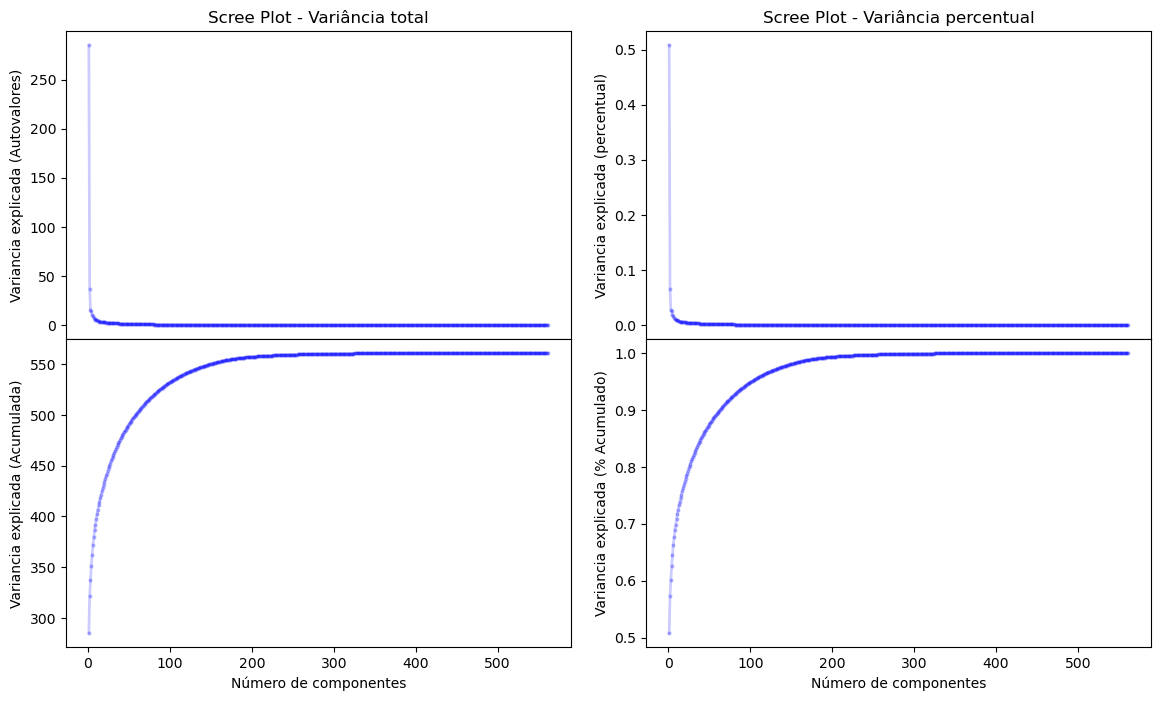

In [18]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

ampli_y1 = princomp.explained_variance_[0]

num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


ampli_y2 = princomp.explained_variance_ratio_[0]
# ax[1].set_ylim(-ampli_y2*.05, ampli_y2*1.1)

ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

plt.show()

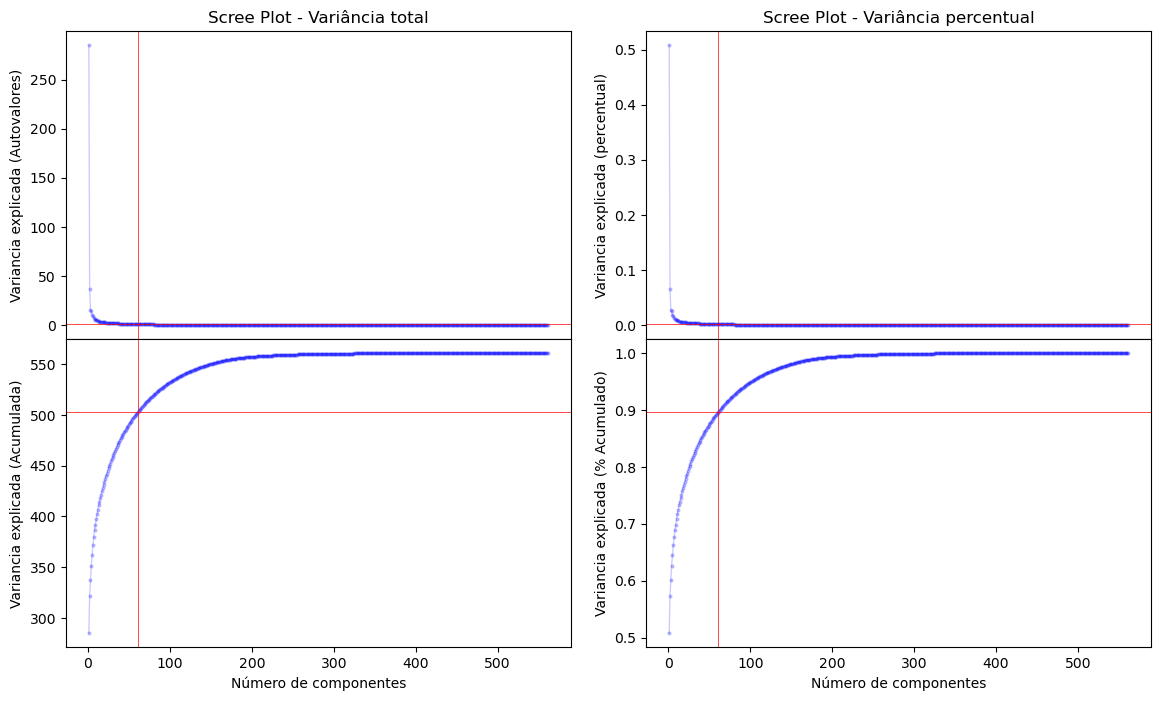

In [19]:
# Critério 1: autovalor padronizado > 1
ncomp_criterio1 = (princomp.explained_variance_ratio_>1/princomp.n_components_).sum()

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd_componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

# Gráfico da variância percentual por qtd_componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

# Gráfico da variância percentual acumulada por qtd_componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)


# linhas horizontais
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

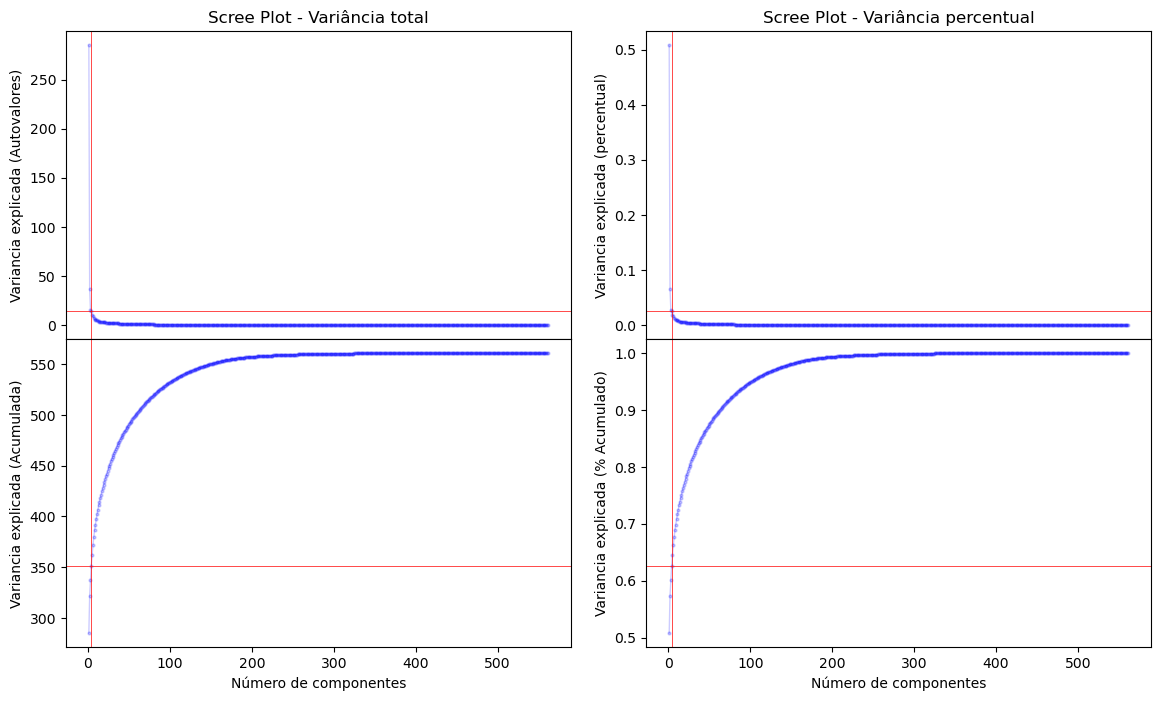

In [20]:
# Critério 2: Método do "cotovelo"
ncomp_criterio2 = 4

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Número de componentes pelo critério 2
ax[0,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

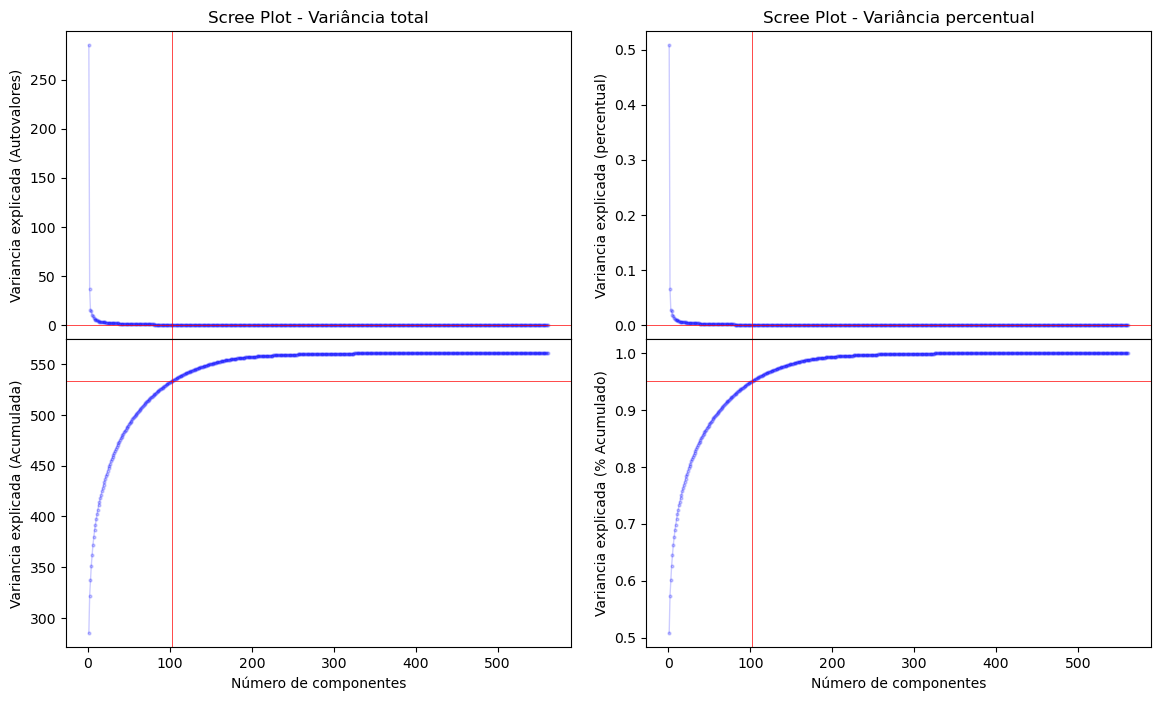

In [21]:
# Critério 3: % variância explicada

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério 3
varexplicada = .95
ncomp_criterio3 = (princomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(princomp.n_components_) + 1
ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ncomp_criterio2 = 50
ax[0,0].axhline(y = princomp.explained_variance_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = princomp.explained_variance_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = princomp.explained_variance_ratio_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [22]:
%%time

#10 componentes
prcomp = PCA(n_components=10).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

pc_treino.shape

Wall time: 277 ms


(7352, 10)

In [23]:
%%time

clf = DecisionTreeClassifier(random_state=1234).fit(X_train, y_train)
caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.append(ccp_alphas, 0.001)

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

Wall time: 6min 9s


In [24]:
%%time
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

Wall time: 2.31 s


In [25]:
%%time
ind_melhor_arvore = len(train_scores) - train_scores[::-1].index(max(train_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

acc_train = train_scores[ind_melhor_arvore]
acc_teste = melhor_arvore.score(X_test, y_test)

print(f'Acurácia da melhor árvore na base de treino:    {acc_train*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {acc_teste*100:.1f}')

Acurácia da melhor árvore na base de treino:    100.0
Acurácia da melhor árvore na base de teste:     85.5
Wall time: 15.6 ms
